In [1]:
import yfinance as yf
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import ta
import warnings
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from matplotlib import pyplot
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from Utils import utils

warnings.filterwarnings('ignore')

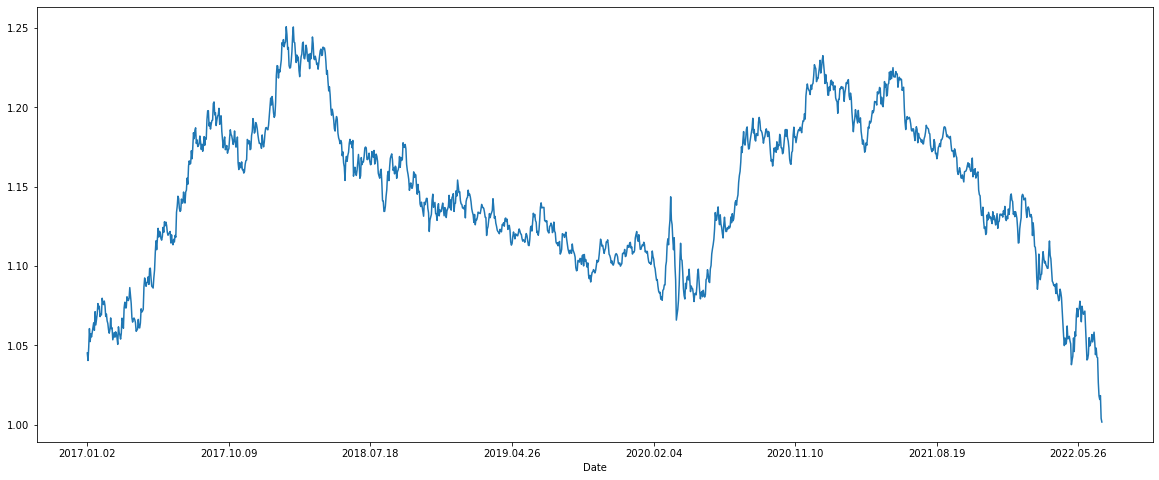

,Open,High,Low,Close,Volume,Median
Date,,,,,,
2017.01.02,1.05100,1.05275,1.04480,1.04519,72920,1.048775
2017.01.03,1.04524,1.04898,1.03399,1.04044,139335,1.041485
2017.01.04,1.04044,1.04996,1.03895,1.04871,138590,1.044455
2017.01.05,1.04871,1.06149,1.04804,1.06055,170836,1.054765
2017.01.06,1.06005,1.06207,1.05235,1.05235,146008,1.057210
...,...,...,...,...,...,...
2022.07.06,1.02641,1.02769,1.01618,1.01810,157888,1.021935
2022.07.07,1.01797,1.02213,1.01441,1.01587,126061,1.018270
2022.07.08,1.01564,1.01912,1.00717,1.01831,131701,1.013145


In [2]:
folder, ticker, period, startdatetime, enddatetime = 'CSVData', 'EURUSD', 'Daily', '201701020000', '202207120000'
multiplier = 100 if 'JPY' in ticker else 10000
ohlcv = pd.read_csv(folder+'/'+ticker+'_'+period+'_'+startdatetime+'_'+enddatetime+'.csv', delimiter='\t')
ohlcv = utils.prep_metatrader_data(ohlcv)
pyplot.figure(figsize=(20,8))
ohlcv['Close'].plot()
pyplot.show()
ohlcv

In [3]:
ohlcv['CandleHeight'] = ohlcv['High'] - ohlcv['Low']

In [4]:
label = 'CandleHeight'
n = 8
X = utils.timeseries_df(ohlcv, label, n)
y = ohlcv[[label]].iloc[n:]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [6]:
regr = MLPRegressor(hidden_layer_sizes=[500, 200], 
                    max_iter=1000, n_iter_no_change=500, verbose=False)

regr.fit(X_train, y_train.to_numpy().ravel())

predicted = regr.predict(X_test)

diff = predicted - y_test[label]
diff_df = pd.DataFrame({'Actual': y_test[label], 
                        'Predicted': predicted,
                        'Difference': diff})

mae = mean_absolute_error(predicted, y_test)
ohlcv_test = ohlcv[ohlcv.index.isin(X_test.index)]
ach = sum(abs(ohlcv_test['High']-ohlcv_test['Low']))/len(diff)
print('Mean absolute error: ' + str(round(mae*multiplier,2)) + ' pips')
print('Average candle range: ' + str(round(ach*multiplier,2)) + ' pips')

Mean absolute error: 25.14 pips
Average candle range: 75.68 pips


In [33]:
label = 'Close'
n = 21
X = utils.timeseries_df(ohlcv, label, n)
y = ohlcv[[label]].iloc[n:]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [35]:
#regr = MLPRegressor(hidden_layer_sizes=[500, 200], 
#                    max_iter=1000, n_iter_no_change=500, verbose=False)

regr = XGBRegressor(n_estimators=500, max_depth=10)

regr.fit(X_train, y_train.to_numpy().ravel())

predicted = regr.predict(X_test)

diff = predicted - y_test[label]
diff_df = pd.DataFrame({'Actual': y_test[label], 
                        'Predicted': predicted,
                        'Difference': diff})

mae = mean_absolute_error(predicted, y_test)
ohlcv_test = ohlcv[ohlcv.index.isin(X_test.index)]
ach = sum(abs(ohlcv_test['High']-ohlcv_test['Low']))/len(diff)
print('Mean absolute error: ' + str(round(mae*multiplier,2)) + ' pips')
print('Average candle range: ' + str(round(ach*multiplier,2)) + ' pips')

Mean absolute error: 57.57 pips
Average candle range: 75.68 pips


In [36]:
y_pred = pd.DataFrame(index = ohlcv_test.index)
y_pred['y_pred'] = predicted
y_pred['low'], y_pred['high'] = ohlcv_test['Low'], ohlcv_test['High']
y_pred['open'], y_pred['close'] = ohlcv_test['Open'], ohlcv_test['Close'] 
y_pred

,y_pred,low,high,open,close
Date,,,,,
2021.06.08,1.221925,1.21643,1.21942,1.21891,1.21726
2021.06.09,1.214266,1.21709,1.22179,1.21722,1.21787
2021.06.10,1.221442,1.21432,1.21950,1.21787,1.21751
2021.06.11,1.221548,1.20927,1.21931,1.21751,1.21063
2021.06.14,1.211273,1.20942,1.21303,1.21025,1.21200
...,...,...,...,...,...
2022.07.06,1.058227,1.01618,1.02769,1.02641,1.01810
2022.07.07,1.058227,1.01441,1.02213,1.01797,1.01587
2022.07.08,1.058227,1.00717,1.01912,1.01564,1.01831


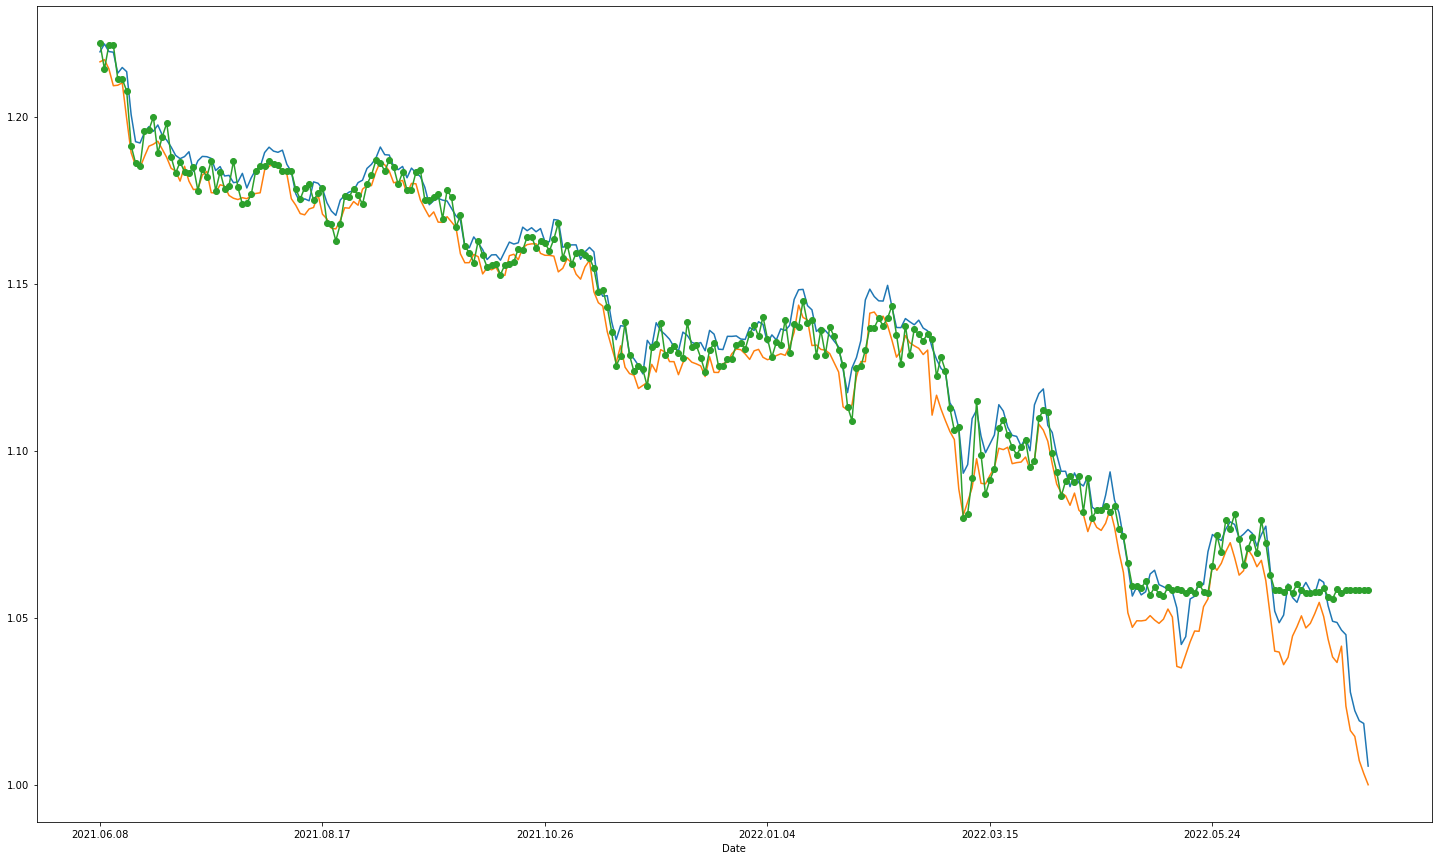

Hitrate: 52.8%
Number of candles: 286


In [37]:
y_pred, hitrate = utils.get_hitrate(y_pred)
pyplot.figure(figsize=(25,15))
y_pred['high'].plot()
y_pred['low'].plot()
y_pred['y_pred'].plot(marker = 'o')
pyplot.show()
print('Hitrate: ' + str(round(hitrate*100,2)) + '%')
print('Number of candles: ' + str(len(y_pred)))

In [38]:
y_pred, direction = utils.get_direction(y_pred)
y_pred, OR = utils.get_OR(y_pred)
y_pred, pips = utils.get_pips(y_pred, multiplier)
print('Direction: ' + str(round(direction*100,2)) + '%')
print('OR: ' + str(round(OR*100,2)) + '%')
print('Total pips: ' + str(round(pips,2)))

Direction: 48.6%
OR: 66.08%
Total pips: -178.85


In [ ]:
y_pred